In [0]:
import random
import math
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt

# parameter
N_SAMPLE = 500  # number of sample_points
N_KNN = 10  # number of edge from one sampled point
MAX_EDGE_LEN = 30.0  # [m] Maximum edge length

show_animation = True


class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, pind):
        self.x = x
        self.y = y
        self.cost = cost
        self.pind = pind

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," + str(self.cost) + "," + str(self.pind)


class KDTree:
    """
    Nearest neighbor search class with KDTree
    """

    def __init__(self, data):
        # store kd-tree
        self.tree = scipy.spatial.cKDTree(data)

    def search(self, inp, k=1):
        """
        Search NN
        inp: input data, single frame or multi frame
        """

        if len(inp.shape) >= 2:  # multi input
            index = []
            dist = []

            for i in inp.T:
                idist, iindex = self.tree.query(i, k=k)
                index.append(iindex)
                dist.append(idist)

            return index, dist

        dist, index = self.tree.query(inp, k=k)
        return index, dist

    def search_in_distance(self, inp, r):
        """
        find points with in a distance r
        """

        index = self.tree.query_ball_point(inp, r)
        return index


def PRM_planning(sx, sy, gx, gy, ox, oy, rr):

    obkdtree = KDTree(np.vstack((ox, oy)).T)

    sample_x, sample_y = sample_points(sx, sy, gx, gy, rr, ox, oy, obkdtree)
    if show_animation:
        plt.plot(sample_x, sample_y, ".b")

    road_map = generate_roadmap(sample_x, sample_y, rr, obkdtree)

    rx, ry = dijkstra_planning(
        sx, sy, gx, gy, ox, oy, rr, road_map, sample_x, sample_y)

    return rx, ry


def is_collision(sx, sy, gx, gy, rr, okdtree):
    x = sx
    y = sy
    dx = gx - sx
    dy = gy - sy
    yaw = math.atan2(gy - sy, gx - sx)
    d = math.sqrt(dx**2 + dy**2)

    if d >= MAX_EDGE_LEN:
        return True

    D = rr
    nstep = round(d / D)

    for i in range(nstep):
        idxs, dist = okdtree.search(np.array([x, y]).reshape(2, 1))
        if dist[0] <= rr:
            return True  # collision
        x += D * math.cos(yaw)
        y += D * math.sin(yaw)

    # goal point check
    idxs, dist = okdtree.search(np.array([gx, gy]).reshape(2, 1))
    if dist[0] <= rr:
        return True  # collision

    return False  # OK


def generate_roadmap(sample_x, sample_y, rr, obkdtree):
    """
    Road map generation
    sample_x: [m] x positions of sampled points
    sample_y: [m] y positions of sampled points
    rr: Robot Radius[m]
    obkdtree: KDTree object of obstacles
    """

    road_map = []
    nsample = len(sample_x)
    skdtree = KDTree(np.vstack((sample_x, sample_y)).T)

    for (i, ix, iy) in zip(range(nsample), sample_x, sample_y):

        index, dists = skdtree.search(
            np.array([ix, iy]).reshape(2, 1), k=nsample)
        inds = index[0]
        edge_id = []
        #print(index)

        for ii in range(1, len(inds)):
            nx = sample_x[inds[ii]]
            ny = sample_y[inds[ii]]

            if not is_collision(ix, iy, nx, ny, rr, obkdtree):
                edge_id.append(inds[ii])

            if len(edge_id) >= N_KNN:
                break

        road_map.append(edge_id)

    #plot_road_map(road_map, sample_x, sample_y)

    return road_map


def dijkstra_planning(sx, sy, gx, gy, ox, oy, rr, road_map, sample_x, sample_y):
    """
    sx: start x position [m]
    sy: start y position [m]
    gx: goal x position [m]
    gy: goal y position [m]
    ox: x position list of Obstacles [m]
    oy: y position list of Obstacles [m]
    rr: robot radius [m]
    road_map: ??? [m]
    sample_x: ??? [m]
    sample_y: ??? [m]
    
    @return: Two lists of path coordinates ([x1, x2, ...], [y1, y2, ...]), empty list when no path was found
    """

    nstart = Node(sx, sy, 0.0, -1)
    ngoal = Node(gx, gy, 0.0, -1)

    openset, closedset = dict(), dict()
    openset[len(road_map) - 2] = nstart

    path_found = True
    
    while True:
        if not openset:
            print("Cannot find path")
            path_found = False
            break

        c_id = min(openset, key=lambda o: openset[o].cost)
        current = openset[c_id]

        # show graph
        if show_animation and len(closedset.keys()) % 2 == 0:
            plt.plot(current.x, current.y, "xg")
            plt.pause(0.001)

        if c_id == (len(road_map) - 1):
            print("goal is found!")
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            break

        # Remove the item from the open set
        del openset[c_id]
        # Add it to the closed set
        closedset[c_id] = current

        # expand search grid based on motion model
        for i in range(len(road_map[c_id])):
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = math.sqrt(dx**2 + dy**2)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + d, c_id)

            if n_id in closedset:
                continue
            # Otherwise if it is already in the open set
            if n_id in openset:
                if openset[n_id].cost > node.cost:
                    openset[n_id].cost = node.cost
                    openset[n_id].pind = c_id
            else:
                openset[n_id] = node
    
    if path_found is False:
        return [], []

    # generate final course
    rx, ry = [ngoal.x], [ngoal.y]
    pind = ngoal.pind
    while pind != -1:
        n = closedset[pind]
        rx.append(n.x)
        ry.append(n.y)
        pind = n.pind

    return rx, ry


def plot_road_map(road_map, sample_x, sample_y):  # pragma: no cover

    for i, _ in enumerate(road_map):
        for ii in range(len(road_map[i])):
            ind = road_map[i][ii]
            plt.plot([sample_x[i], sample_x[ind]],
                     [sample_y[i], sample_y[ind]], "-k")


def sample_points(sx, sy, gx, gy, rr, ox, oy, obkdtree):
    maxx = max(ox)
    maxy = max(oy)
    minx = min(ox)
    miny = min(oy)

    sample_x, sample_y = [], []

    while len(sample_x) <= N_SAMPLE:
        tx = (random.random() * (maxx - minx)) + minx
        ty = (random.random() * (maxy - miny)) + miny

        index, dist = obkdtree.search(np.array([tx, ty]).reshape(2, 1))

        if dist[0] >= rr:
            sample_x.append(tx)
            sample_y.append(ty)

    sample_x.append(sx)
    sample_y.append(sy)
    sample_x.append(gx)
    sample_y.append(gy)

    return sample_x, sample_y


def main():
    print(" start!!")

     # start and goal position
    sx = 6.0  # [m]
    sy = 14.0  # [m]
    gx = 32.0  # [m]
    gy = 32.0  # [m]
    robot_size = 5.0  # [m]

    ox = [14, 15, 16, 37, 38, 39, 14, 15, 16, 37, 38, 39, 26, 27, 28, 26, 27, 28, 10, 11, 12, 10, 11, 12, 34, 35, 36, 34, 35, 36]
    oy = [10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 23, 23, 23, 24, 24, 24, 34, 34, 34, 35, 35, 35, 42, 42, 42, 43, 43, 43]

    if show_animation:
        plt.plot(ox, oy, "gs")
        plt.plot(sx, sy, 'bo')
        plt.plot(gx, gy, 'ro')
        plt.grid(True)
        plt.axis("equal")

    rx, ry = PRM_planning(sx, sy, gx, gy, ox, oy, robot_size)

    assert rx, 'Cannot found path'

    if show_animation:
        plt.plot(rx, ry, "-r")
        plt.show()
        print(rx)
        print(ry)

 start!!


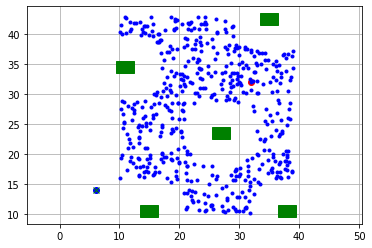

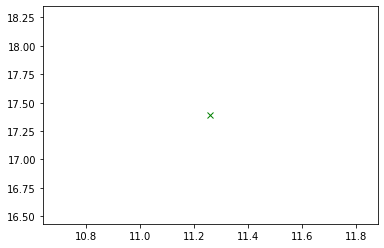

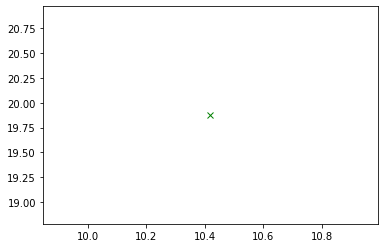

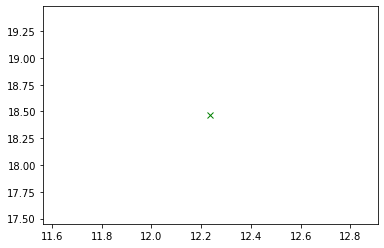

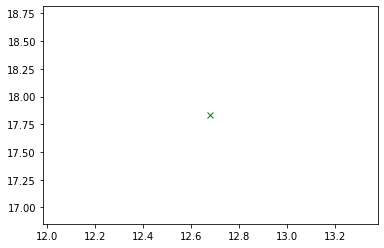

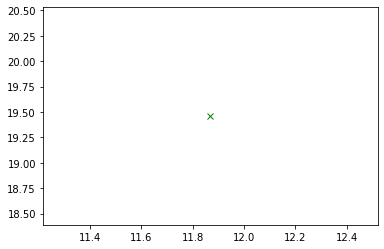

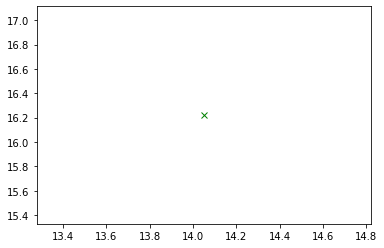

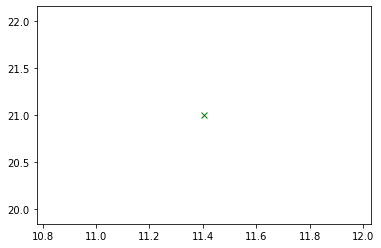

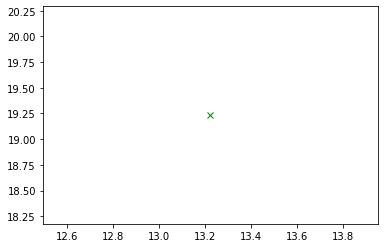

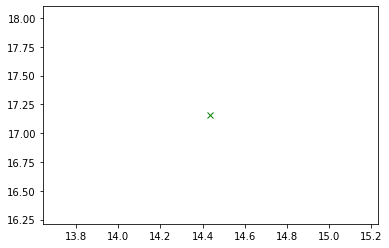

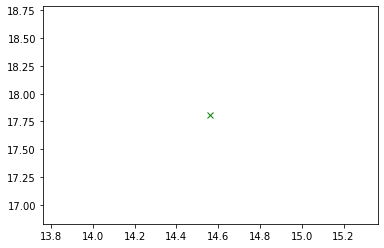

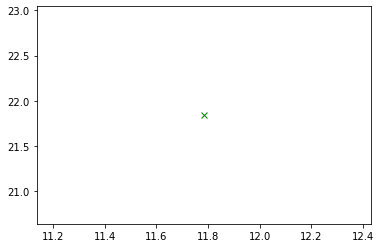

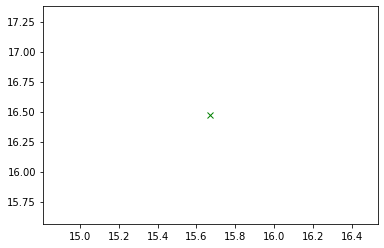

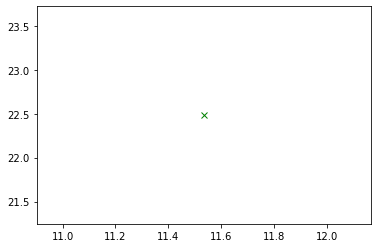

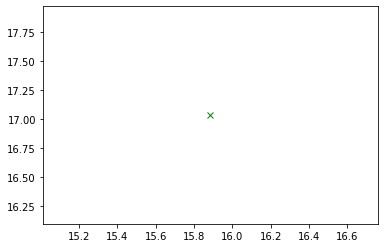

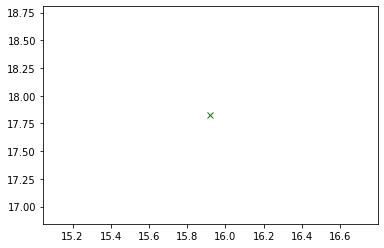

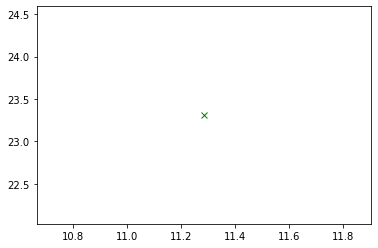

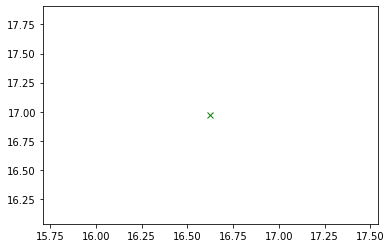

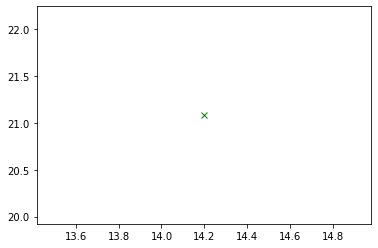

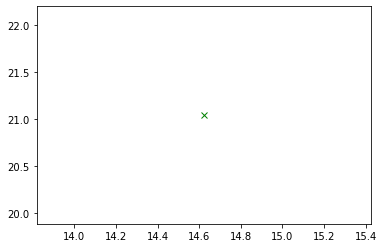

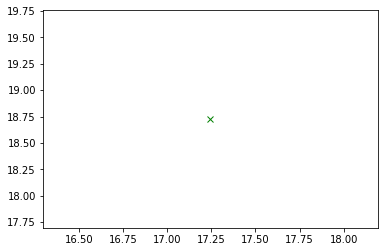

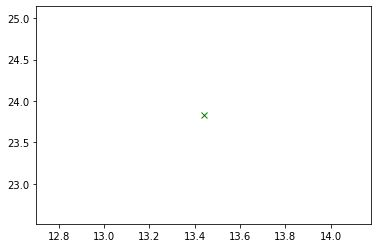

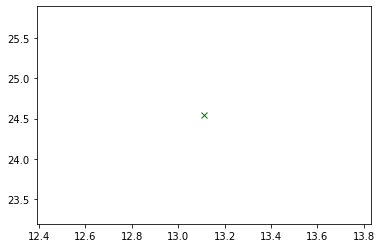

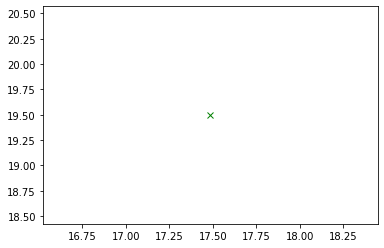

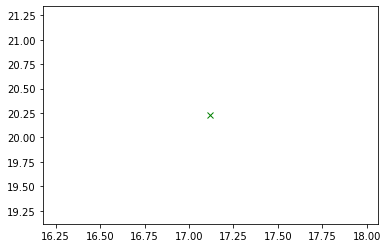

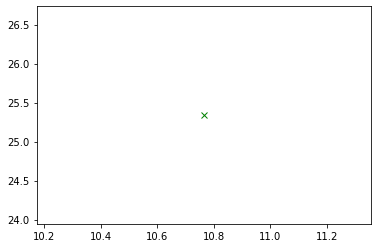

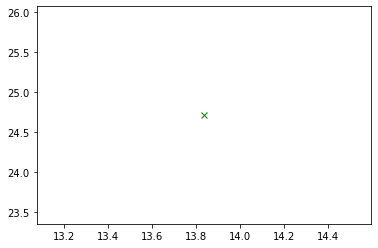

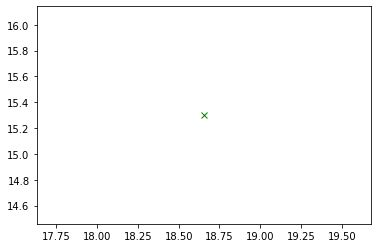

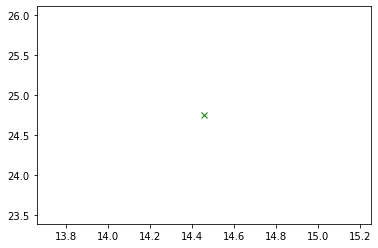

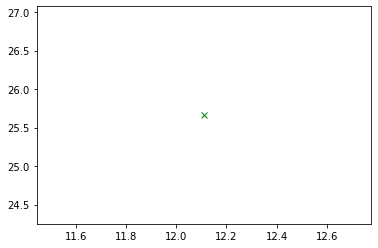

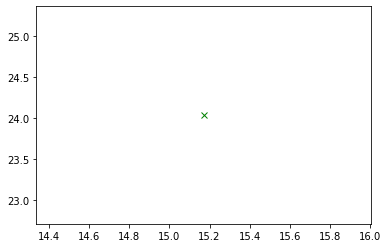

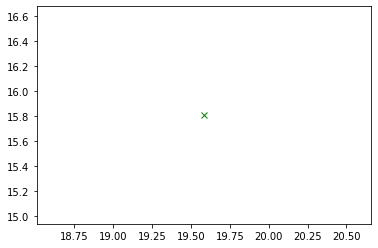

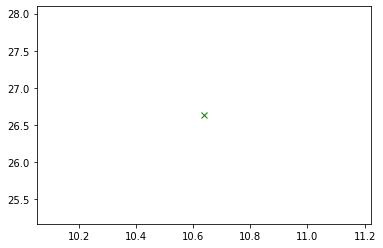

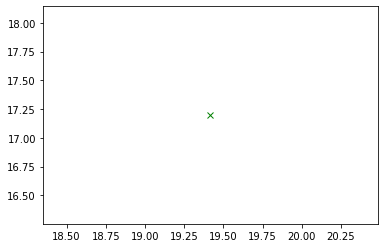

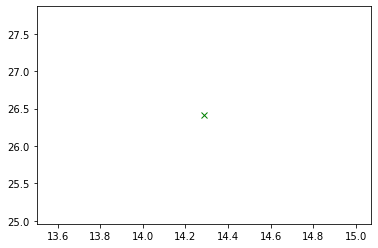

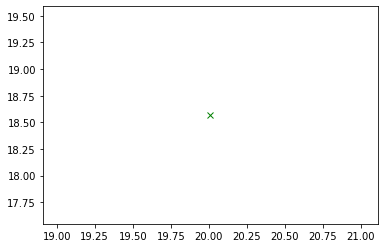

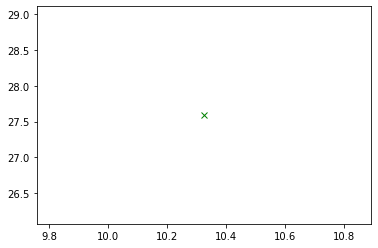

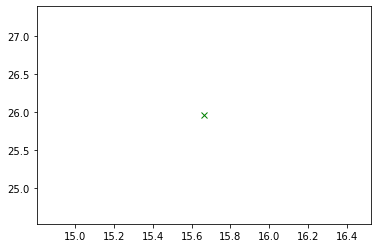

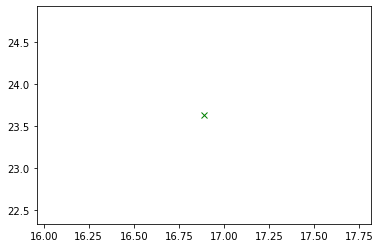

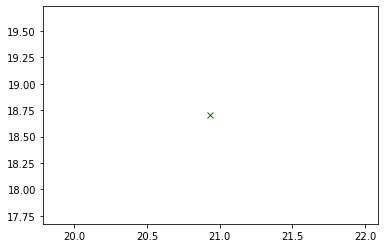

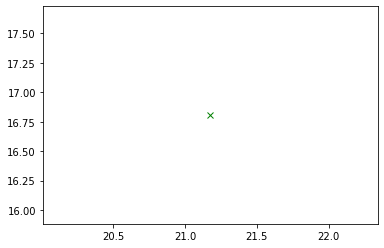

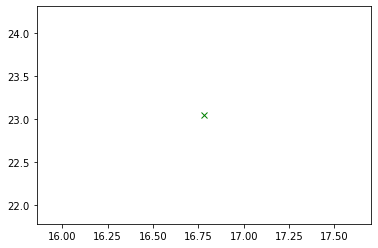

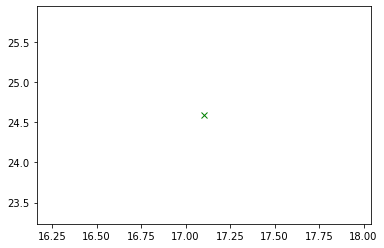

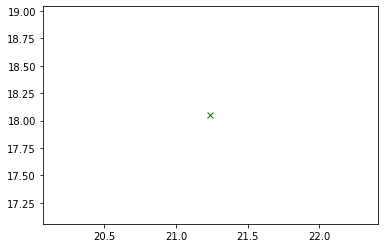

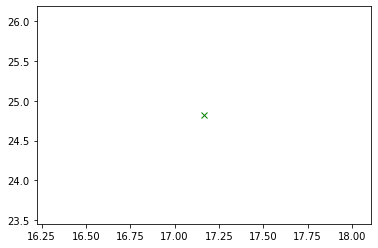

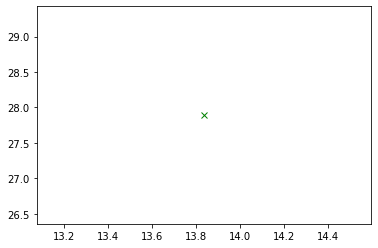

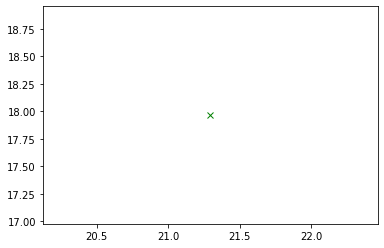

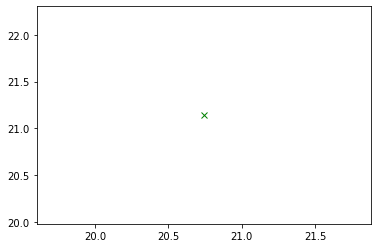

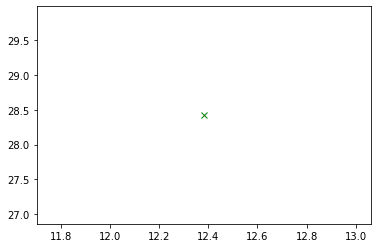

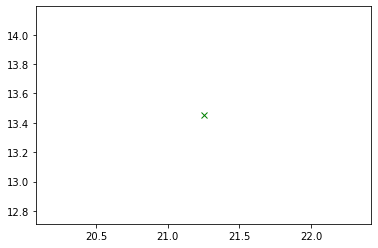

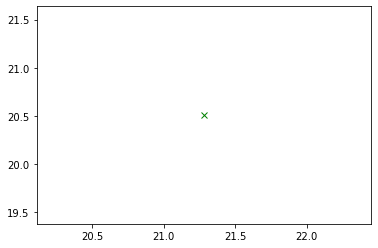

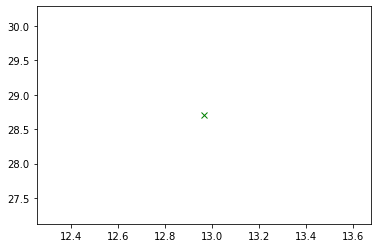

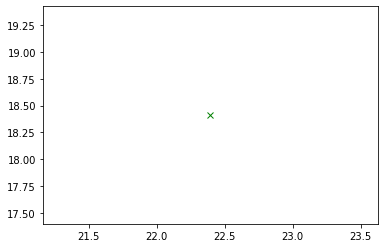

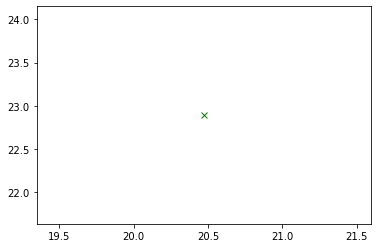

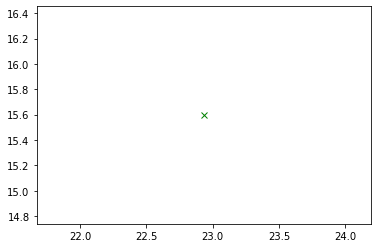

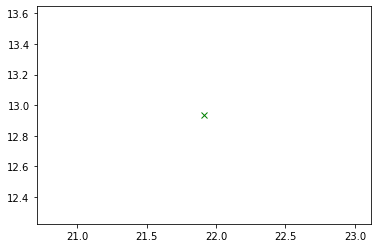

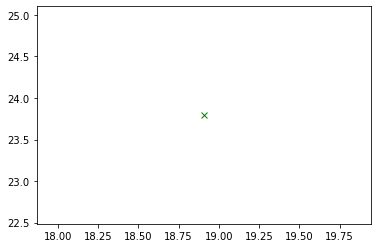

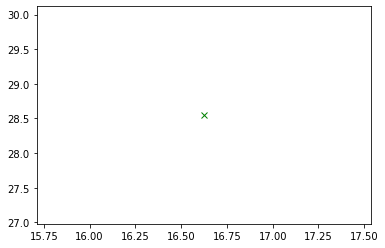

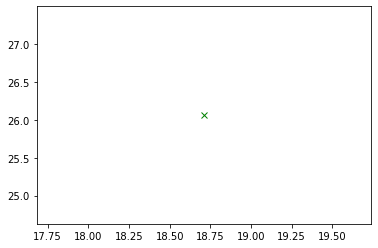

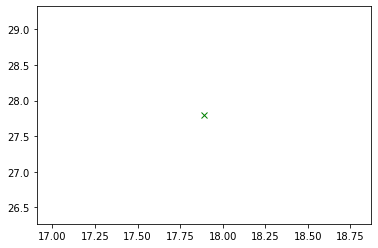

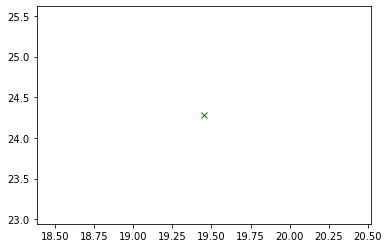

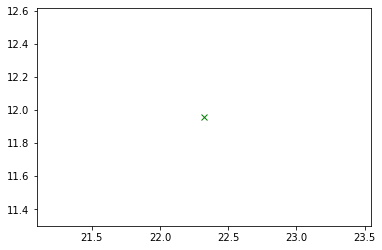

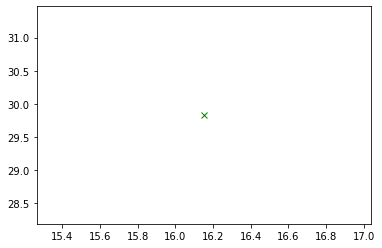

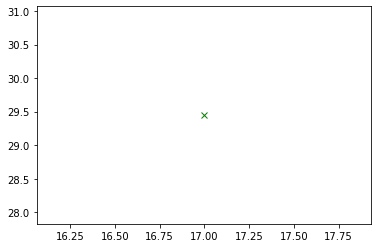

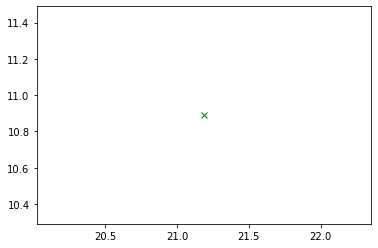

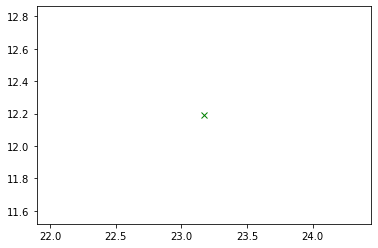

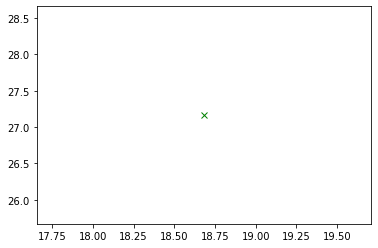

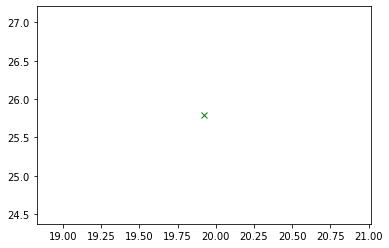

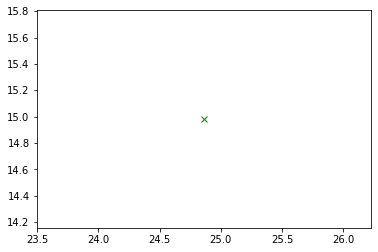

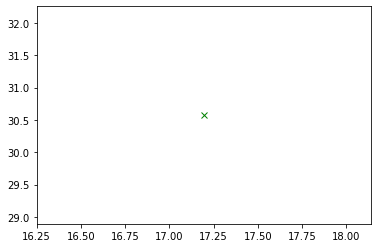

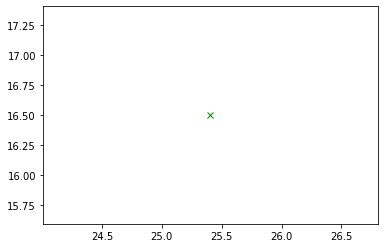

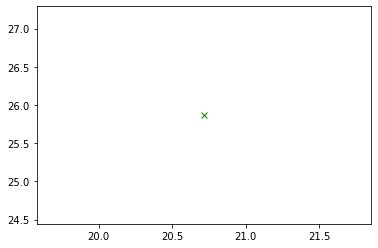

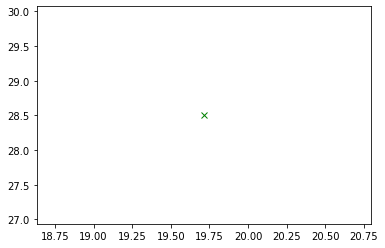

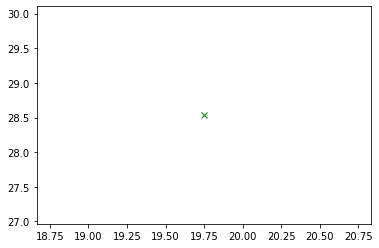

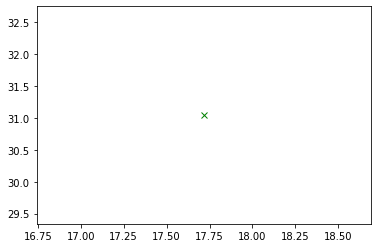

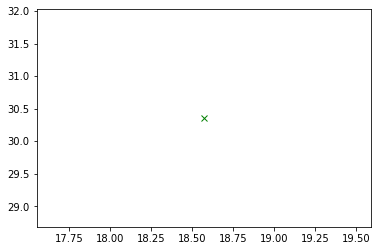

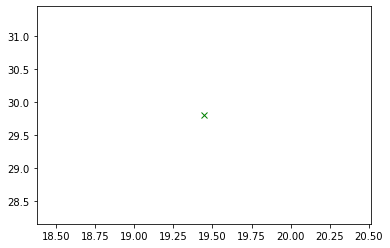

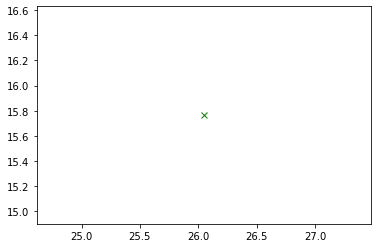

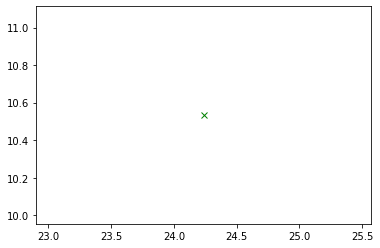

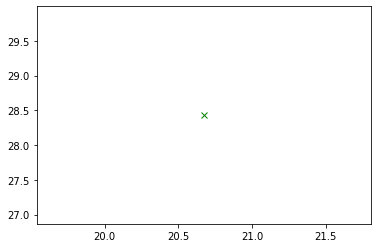

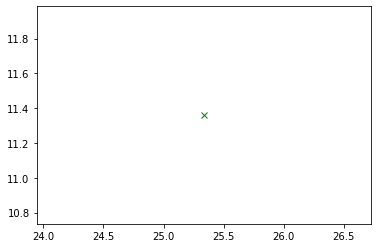

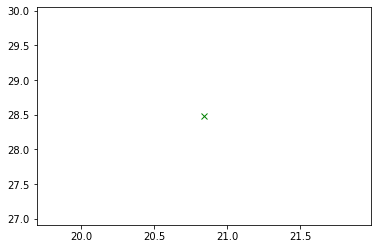

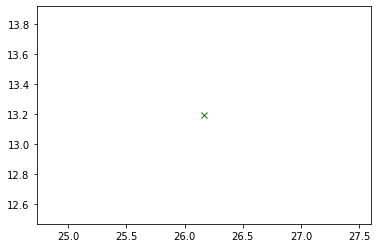

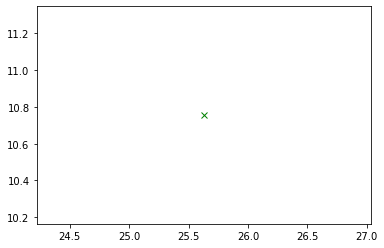

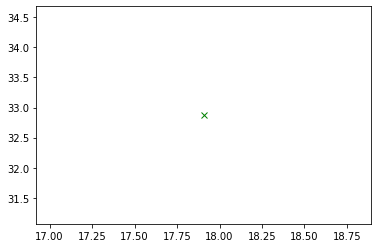

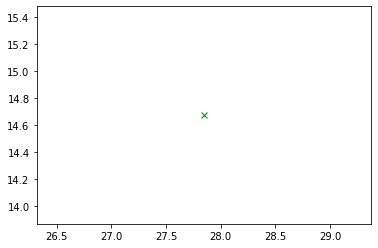

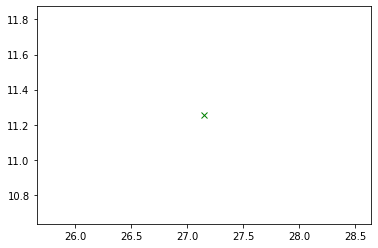

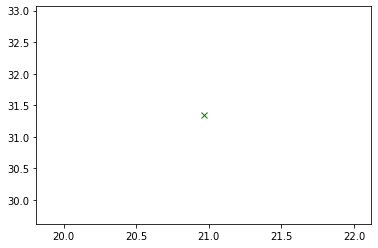

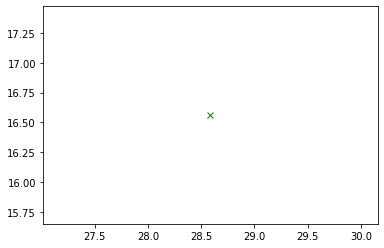

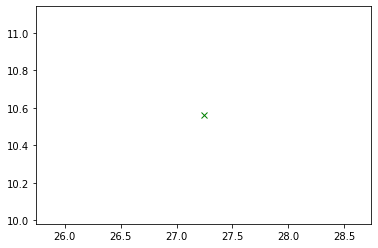

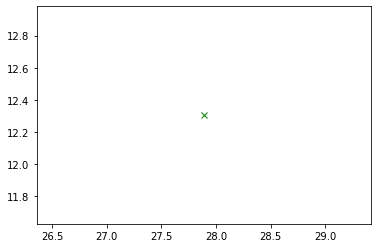

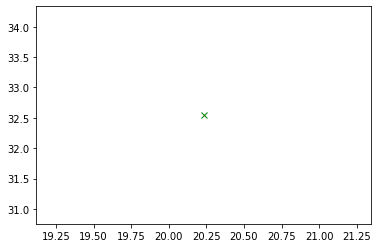

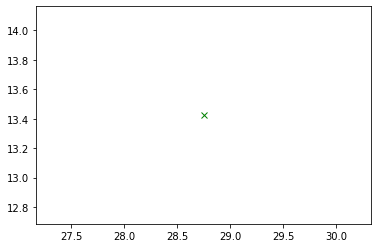

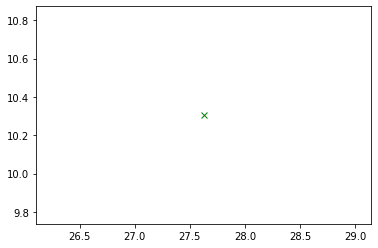

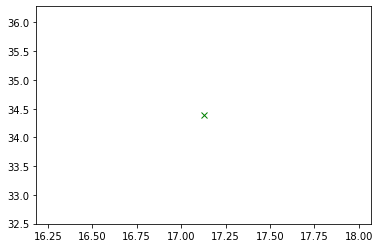

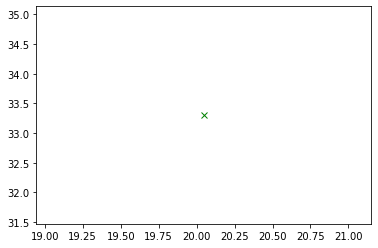

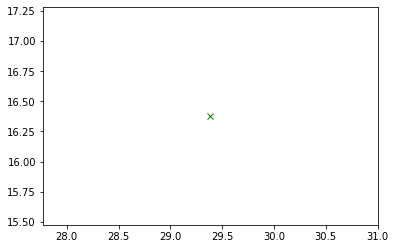

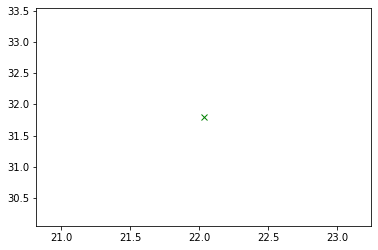

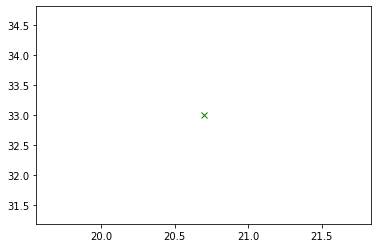

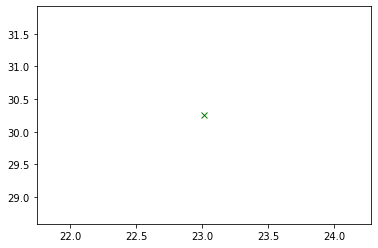

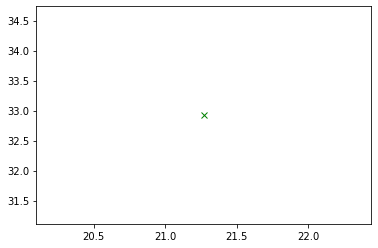

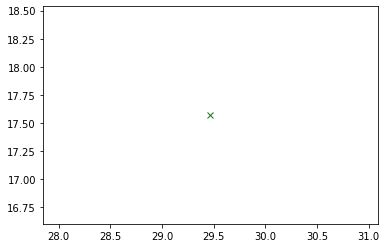

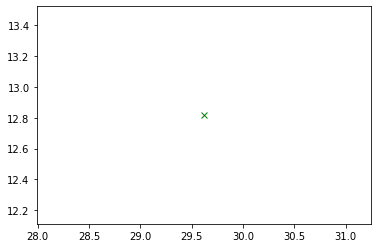

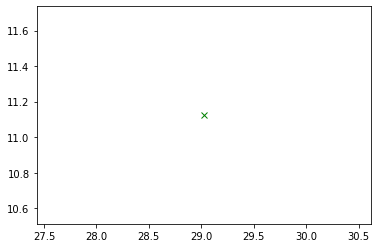

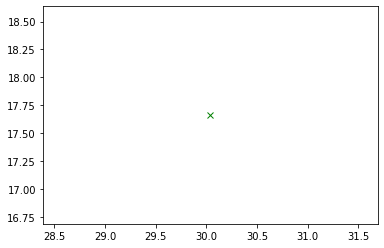

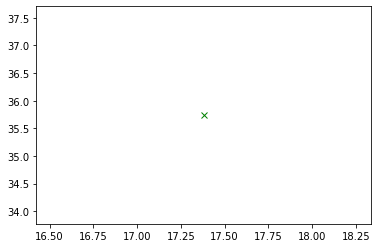

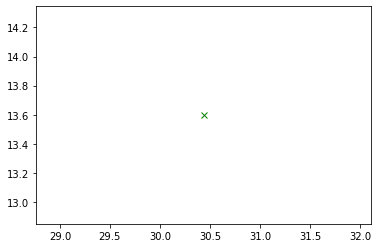

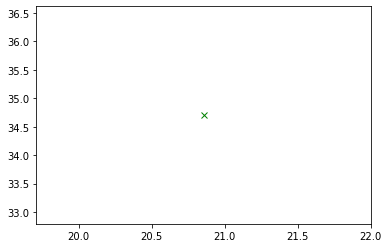

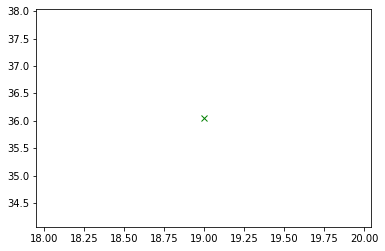

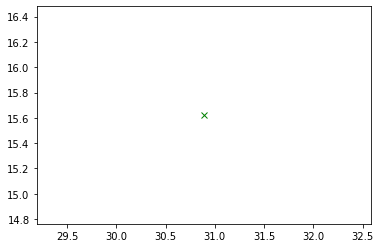

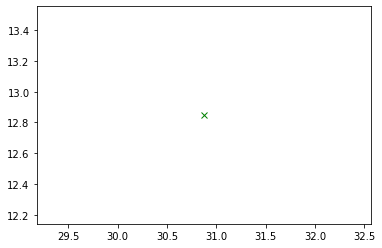

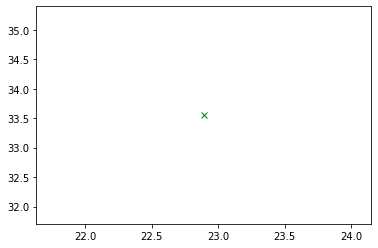

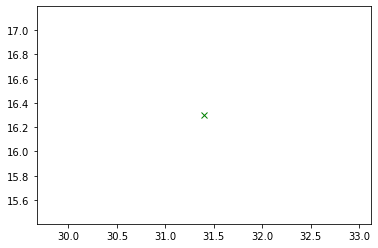

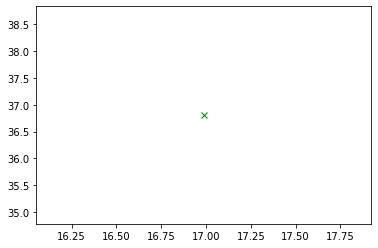

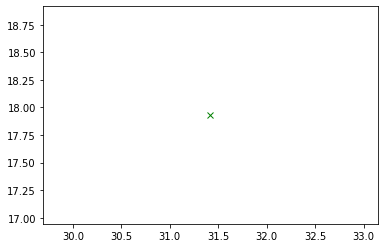

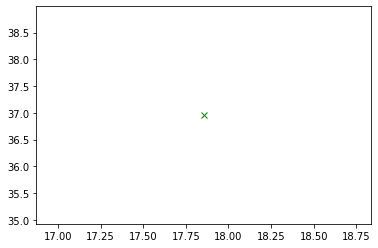

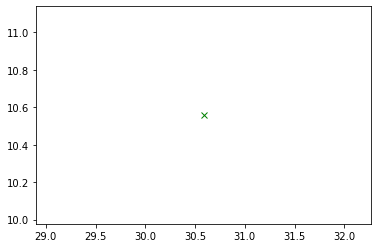

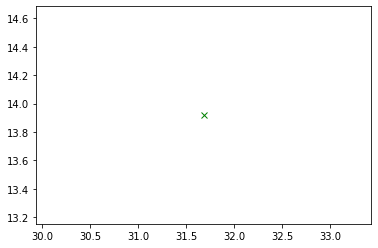

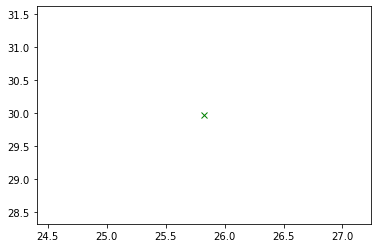

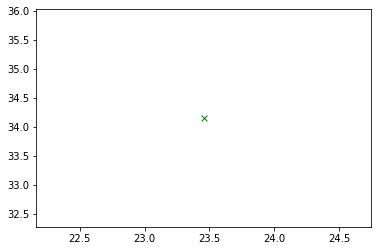

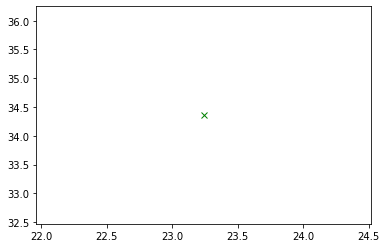

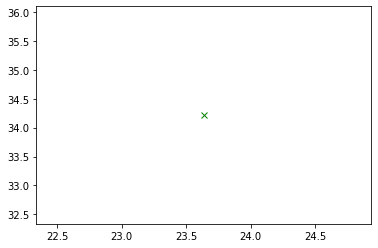

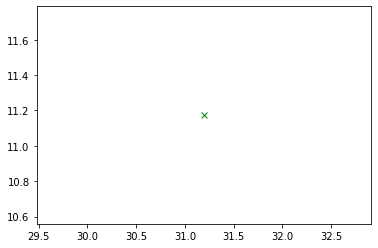

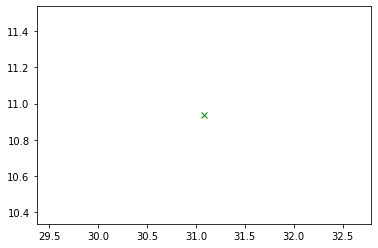

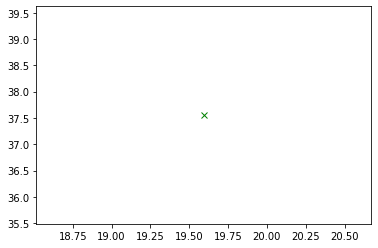

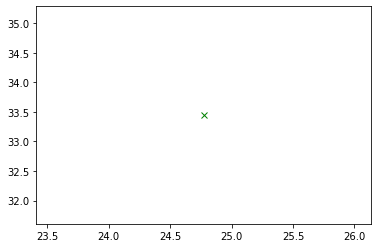

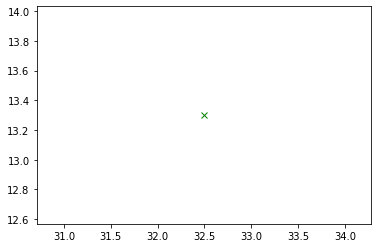

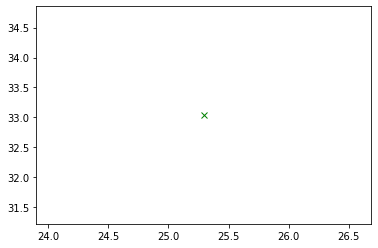

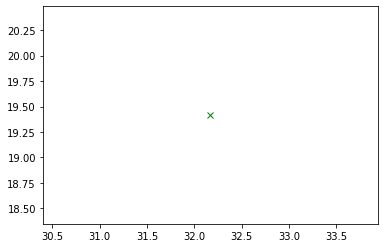

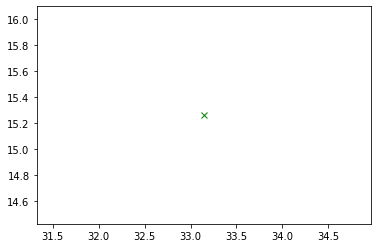

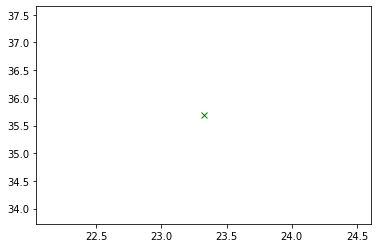

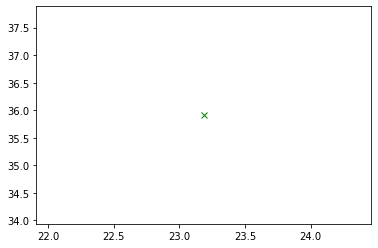

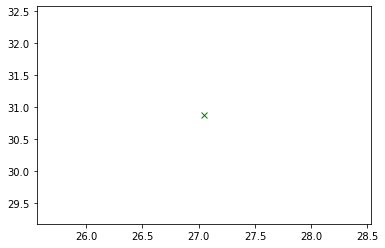

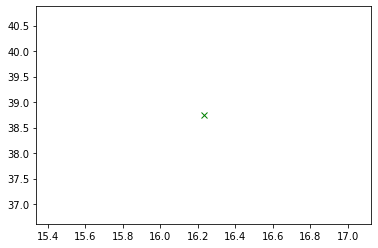

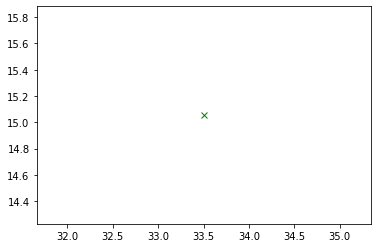

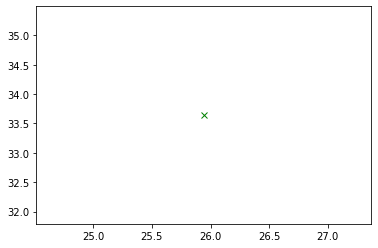

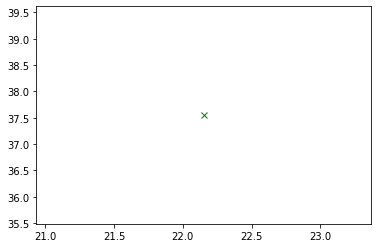

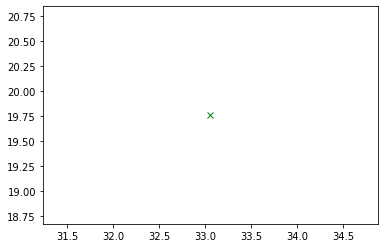

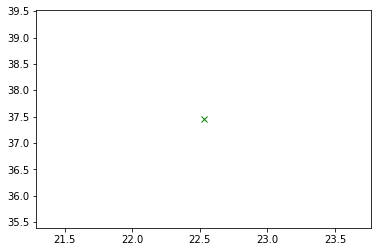

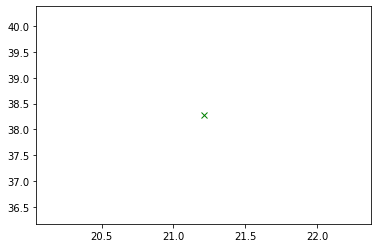

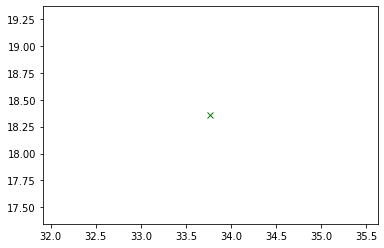

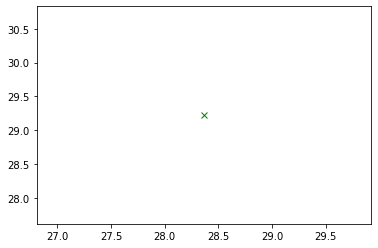

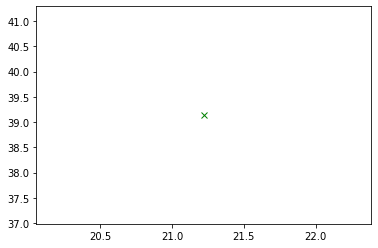

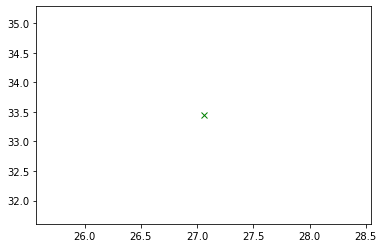

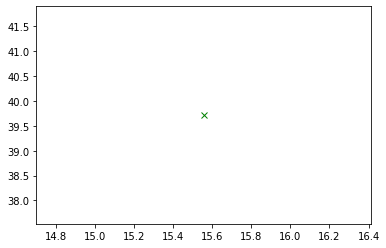

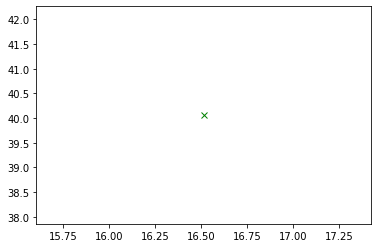

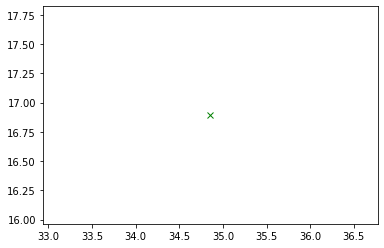

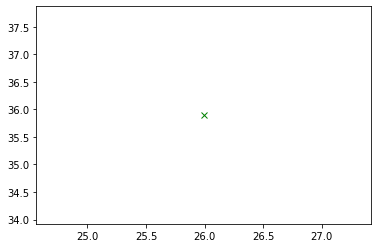

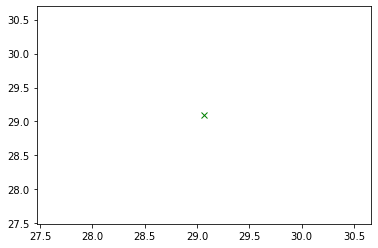

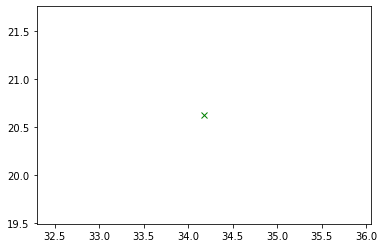

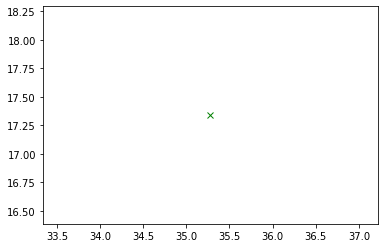

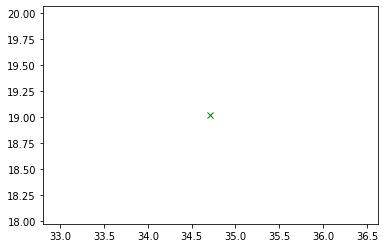

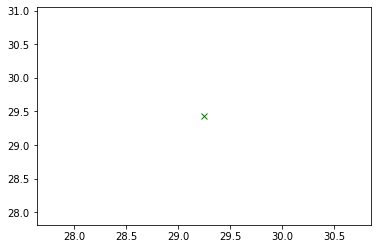

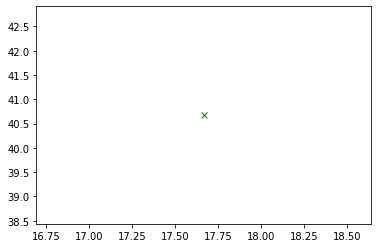

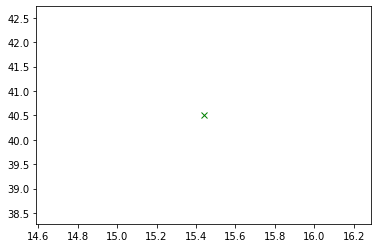

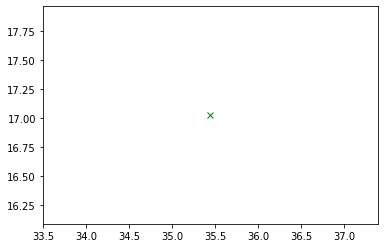

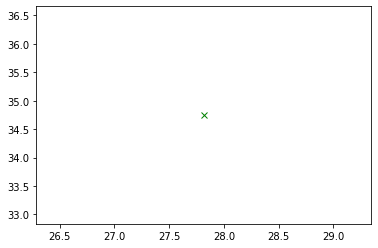

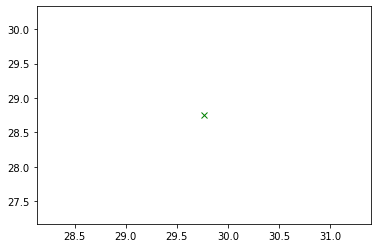

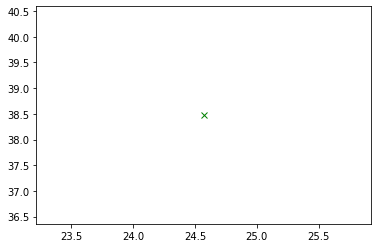

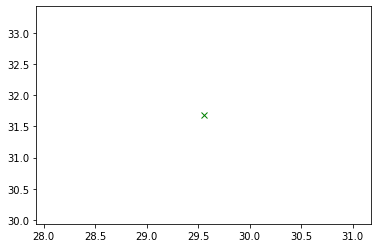

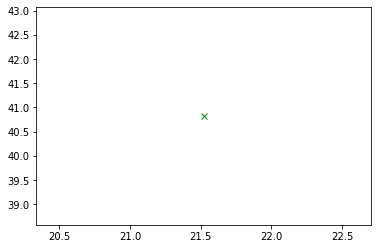

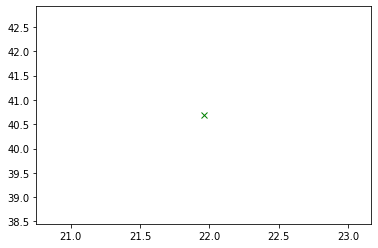

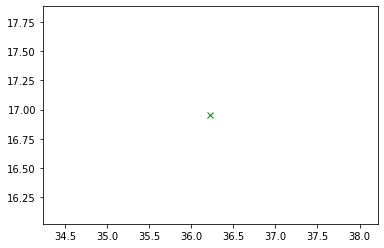

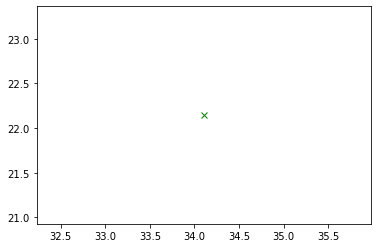

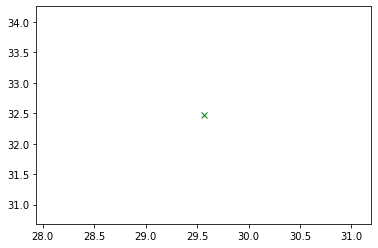

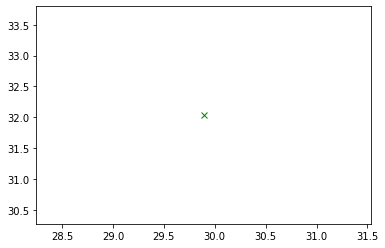

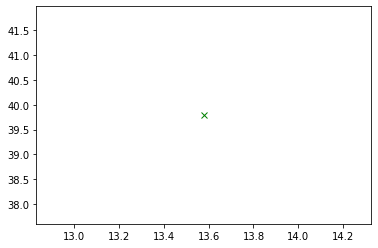

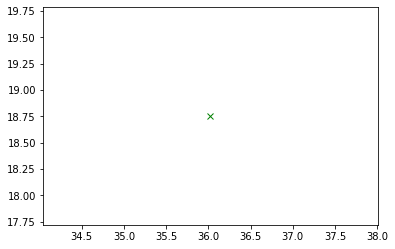

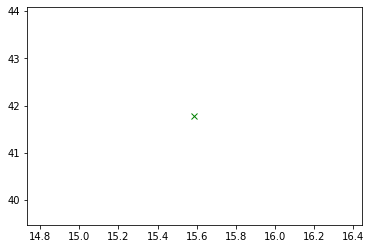

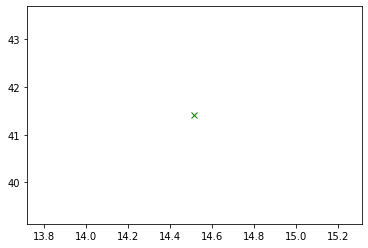

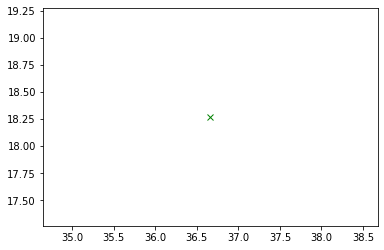

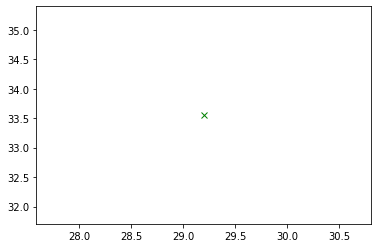

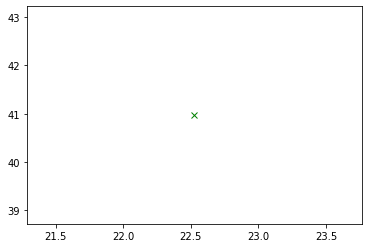

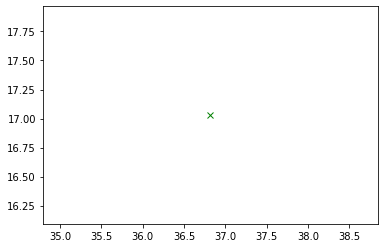

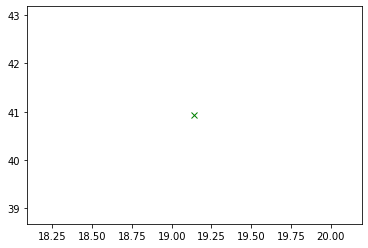

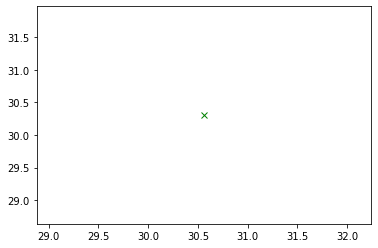

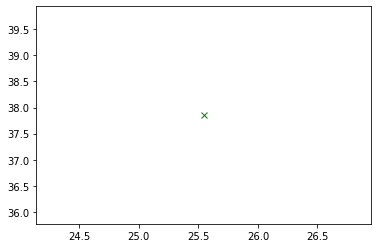

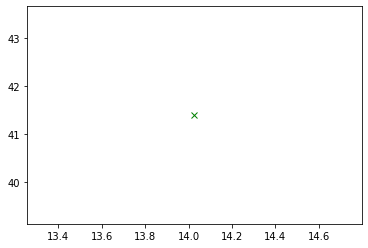

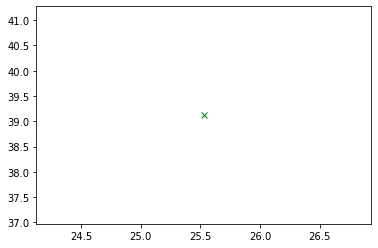

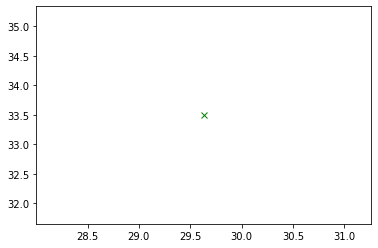

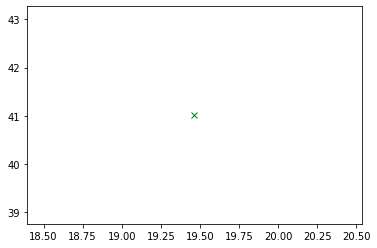

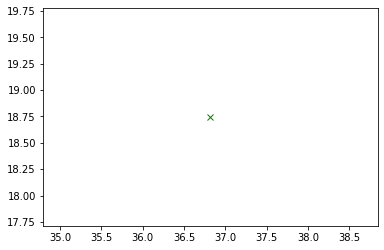

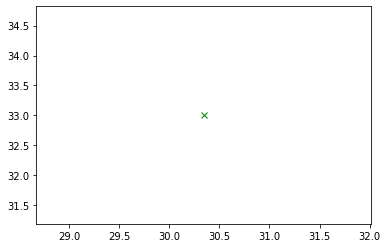

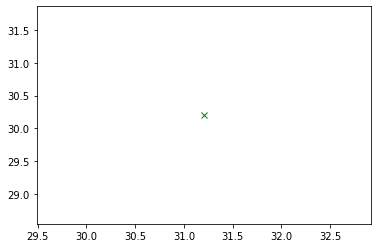

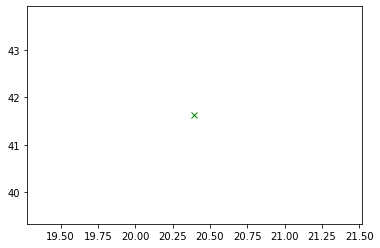

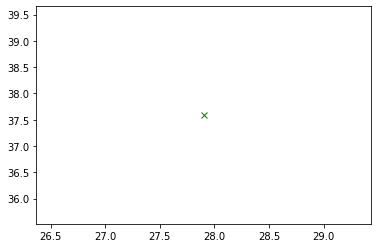

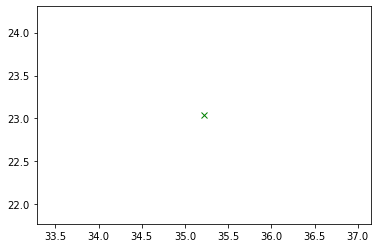

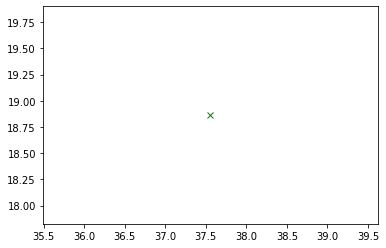

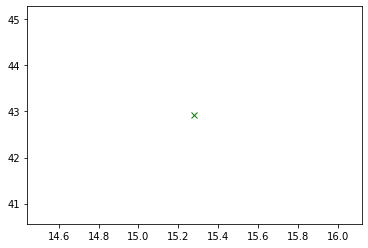

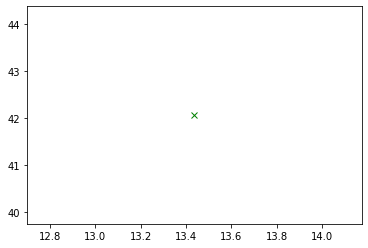

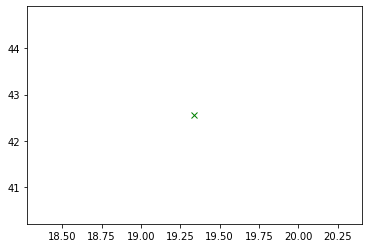

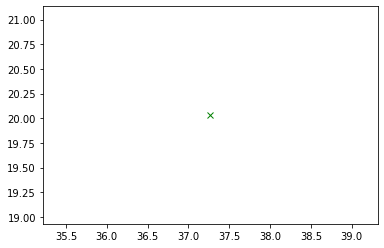

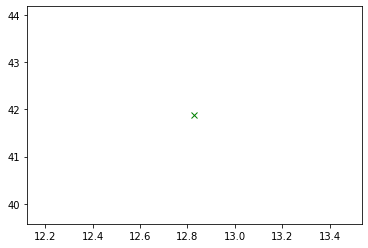

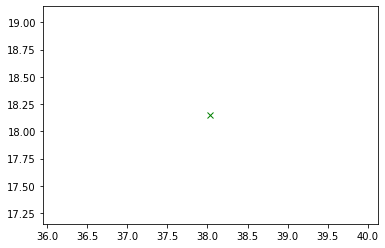

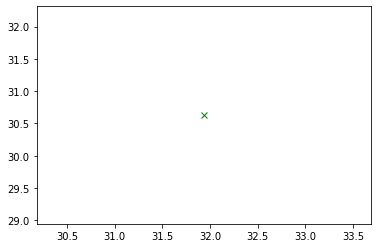

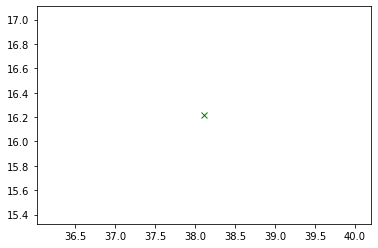

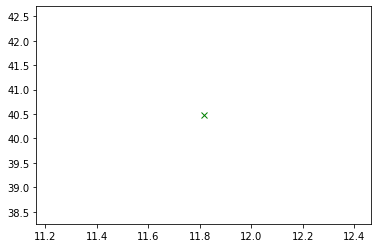

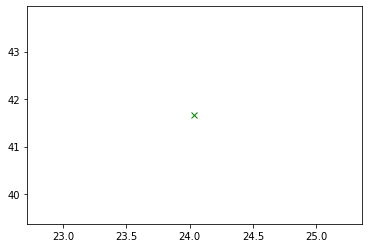

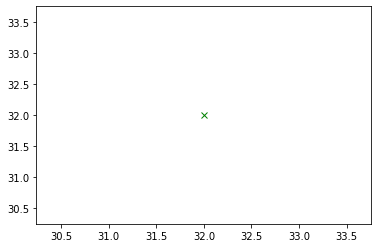

goal is found!


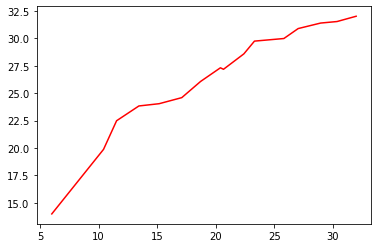

[32.0, 30.366886971305448, 28.966306038725556, 27.04704197291322, 25.824811289721183, 23.31306377838438, 22.407030168385994, 20.66685037878552, 20.404612415064502, 18.710598848937515, 17.103277483219244, 15.171695508232999, 13.44004781784207, 11.535580678135908, 10.419133101925038, 6.0]
[32.0, 31.51824650302594, 31.37989427967834, 30.878222675622087, 29.971685804284576, 29.734773306946153, 28.573668840639034, 27.169265323639003, 27.305938533263944, 26.061792889360618, 24.58843676148045, 24.036695364348724, 23.830065683131757, 22.48422338866441, 19.875744306114623, 14.0]


In [0]:
main()